In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from src.XAI.concepts import concept_instances

In [3]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [4]:
concept_cavs = {}
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if score > 0.0: # Adjust if wanted
        cav = probe[1].weight.data.cpu().numpy().squeeze()
        concept_cavs[concept.name] = cav
        print(f"{concept.name:^35} | {score:^10.4f} | yes")
    else:
        print(f"{concept.name:^35} | {score:^10.4f} | no")

           random binary            |   0.0300   | yes
         random continuous          |   0.0650   | yes
          total wall area           |   0.7590   | yes
          player on grass           |   0.9800   | yes
           player in air            |   0.9660   | yes
          player dodging            |   0.9560   | yes
          player on wall            |   0.9630   | yes
      player dodging on wall        |   0.9660   | yes
          events quantity           |   0.6380   | yes
       good events quantity         |   0.7740   | yes
        bad events quantity         |   0.7680   | yes
           visible wall             |   0.9330   | yes
         visible air wall           |   0.8870   | yes
          visible bullet            |   0.8990   | yes
           visible lava             |   0.9260   | yes
         visible blue coin          |   0.8830   | yes
         visible gold coin          |   0.9950   | yes
         visible red coin           |   0.3810   | yes
         v

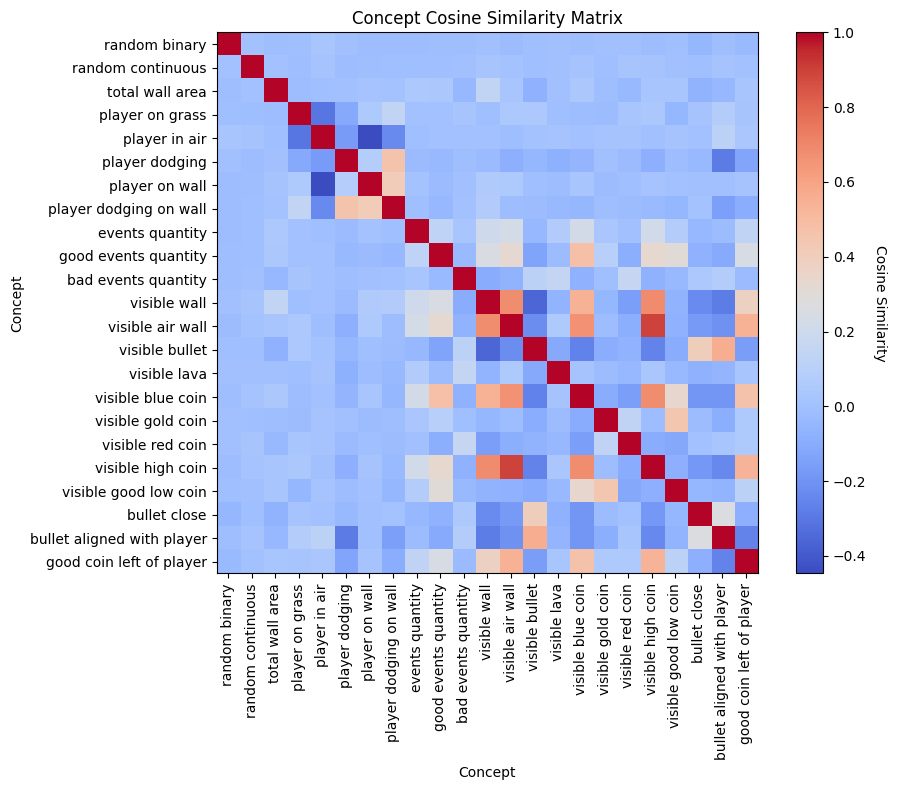

In [5]:
num_concepts = len(concept_cavs)
similarity_matrix = np.zeros((num_concepts, num_concepts))

# Populate the matrix
for i, concept1 in enumerate(concept_cavs):
    for j, concept2 in enumerate(concept_cavs):
        similarity_matrix[i, j] = cosine_similarity(concept_cavs[concept1], concept_cavs[concept2])

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
# set x and y labels
plt.xlabel('Concept')
plt.ylabel('Concept')
cbar = plt.colorbar()
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15)
plt.title('Concept Cosine Similarity Matrix')
plt.xticks(np.arange(num_concepts), concept_cavs.keys(), rotation=90)
plt.yticks(np.arange(num_concepts), concept_cavs.keys())
plt.tight_layout()
plt.savefig('figures/concept_similarity.png', dpi=300)
plt.show()

In [6]:
pairs_with_scores = []
for i, concept1 in enumerate(concept_cavs.keys()):
    for j, concept2 in enumerate(concept_cavs.keys()):
        if i < j:  # No duplicate pairs
            similarity = cosine_similarity(concept_cavs[concept1], concept_cavs[concept2])
            pairs_with_scores.append(((concept1, concept2), similarity))

# Sort pairs based on similarity
sorted_pairs = sorted(pairs_with_scores, key=lambda x: x[1], reverse=True)

# Extract top x and bottom x correlated concept pairs
x = 10
top_x_concepts = sorted_pairs[:x]
bottom_x_concepts = sorted_pairs[-x:]

print(f"Top {x} closest concepts:\n")
print(f"{'Concept 1':^40} | {'Concept 2':^40} | {'Score':^10}")
print('-' * 100)
for (pair, score) in top_x_concepts:
    print(f"{pair[0]:^40} | {pair[1]:^40} | {score:^10.4f} |")

print(f"\nBottom {x} closest concepts:\n")
print(f"{'Concept 1':^40} | {'Concept 2':^40} | {'Score':^10}")
print('-' * 100)
for (pair, score) in bottom_x_concepts:
    print(f"{pair[0]:^40} | {pair[1]:^40} | {score:^10.4f} |")

Top 10 closest concepts:

               Concept 1                 |                Concept 2                 |   Score   
----------------------------------------------------------------------------------------------------
            visible air wall             |            visible high coin             |   0.8958   |
              visible wall               |            visible high coin             |   0.6848   |
           visible blue coin             |            visible high coin             |   0.6833   |
              visible wall               |             visible air wall             |   0.6822   |
            visible air wall             |            visible blue coin             |   0.6625   |
             visible bullet              |        bullet aligned with player        |   0.5603   |
              visible wall               |            visible blue coin             |   0.5415   |
            visible air wall             |         good coin left of player        